# Laboratorio Final: "Armado de un esquema de aprendizaje automático"
### Alumno: Maximiliano Armesto

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

---
## Librerías y semilla

In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ml.visualization import plot_confusion_matrix, classifier_boundary
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import axes3d
np.random.seed(0)  #Para mayor determinismo

---
## Carga de datos

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [30]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")
print('\nLongitud del dataset: '+str(len(dataset))+'\n')

#División entre instancias y etiquetas
X, y = dataset.drop(columns=['TARGET']), dataset.TARGET

print('Dataset:')
display(X.head(10))

print('Target:')
display(y.head(10))

print('Frecuencias del Target')
display(dataset.TARGET.value_counts())


Longitud del dataset: 1854

Dataset:


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
5,11500,53651.0,87547.0,18.0,0.0,0.0,191.396887,0.0,16.0,34.368651
6,17200,103519.0,118074.0,0.0,0.0,0.0,102.678612,1.0,21.0,41.418353
7,24200,22763.0,47622.0,23.0,0.0,0.0,126.922691,1.0,10.0,23.040945
8,12600,62493.0,77141.0,13.0,0.0,0.0,266.333101,0.0,26.0,27.007872
9,12300,90006.0,121122.0,9.0,0.0,0.0,133.497541,1.0,21.0,36.910482


Target:


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: TARGET, dtype: int64

Frecuencias del Target


0    1545
1     309
Name: TARGET, dtype: int64

Se puede ver que el problema de aprendizaje autómatico del corriente laboratorio, entra dentro de la categoría de un problema de `clasificación binaria`.

---
## Ejercicio 1: División de datos en conjuntos de entrenamiento y evaluación

La primer tarea consiste en dividir el conjunto de datos cargados en el apartado anterior en conjuntos de entrenamiento (o *training*) y evaluación (o *test*).

El primero será utilizado para la creación/selección del modelo de clasificación. El segundo se utilizará sólo al final (una vez elegidos los mejores hiperparámetros) para ver cuál es el resultado final del modelo sobre un conjunto de datos independiente.

In [31]:
# Utilizamos aproximadamente 80% de los datos para entrenamiento y 20% para validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Necesario para poder hacer un regresor por feature
feature_map = {feature: idx for idx, feature in enumerate(['LOAN', 'MORTDUE','VALUE','YOJ','DEROG','DELINQ', 
                                                           'CLAGE','NINQ','CLNO', 'DEBTINC'])}
print("Listado de atributos\n====================")
for feature in feature_map:
    print("- %s" % feature)

Listado de atributos
- LOAN
- MORTDUE
- VALUE
- YOJ
- DEROG
- DELINQ
- CLAGE
- NINQ
- CLNO
- DEBTINC


---
## Ejercicio 2: Elección de un modelo

Basándose en lo visto en el teórico escojan y justifiquen un modelo de aprendizaje automático. Recuerden que los pasos para elegir un modelo son:

### Selección de hipótesis

Elegimos a la regresión logística, con función:

$$h_w(x)= \frac{1}{1+\exp(-w^T x))}$$

### Selección de regularizador

Se va a calcular cual de los dos regularizadores (`L1` y `L2`) presenta mejores resultados y se procederá a elegirlo por rendimiento.

### Selección de función de coste

$$L(w)=- \sum_{i=1}^N y_i \log (h_w(x_i)) + (1-y_i) \log (1-h_w(x_i))$$

### Justificación de las selecciones

Como se mencionó anteriormente, el problema cae dentro de un problema de `clasificación binaria`, para la cual se escoge a la regresión logística como hipótesis, ya que la salida toma valores de 0 y/o 1. Además, la regresión será de atributos regulares, se escogió esta característica para simplificar el modelo, ya que se utilizarán todos los `features` del dataset. Esto se decidió luego de probar diversas combinaciones de datos y descubrir que los conjuntos no eran para nada linealmente separables, lo que nos llevo a encontrar que usando todas las features mejorábamos la exactitud. En cuanto al regularizador, se escogerá `L2` simplemente debido a que es más usada y brinda mejores resultados en general que `L1`.

---

## Ejercicio 3: Selección de hiperparámetros

Utilizando búsqueda exhaustiva (*grid search*) con *5-fold cross-validation* y utilizando como métrica el área bajo la curva de ROC (o *ROC-AUC*), hagan una selección de los mejores hiperparámetros para su conjunto de datos y el modelo que hayan elegido en el apartado anterior.

### Búsqueda de parámetros

####################################################################
    Exploración de hiperparámetros para función de coste "l1"    
####################################################################

Mejor conjunto de parámetros:
{'C': 1.1111111111111112, 'max_iter': 20000, 'tol': 0.001}

Puntajes de la grilla:
Exactitud: 0.758 (+/-0.002) para los parámetros {'C': 0.025, 'max_iter': 10000, 'tol': 0.001}
Exactitud: 0.758 (+/-0.002) para los parámetros {'C': 0.025, 'max_iter': 10000, 'tol': 1e-05}
Exactitud: 0.758 (+/-0.002) para los parámetros {'C': 0.025, 'max_iter': 15000, 'tol': 0.001}
Exactitud: 0.758 (+/-0.002) para los parámetros {'C': 0.025, 'max_iter': 15000, 'tol': 1e-05}
Exactitud: 0.758 (+/-0.002) para los parámetros {'C': 0.025, 'max_iter': 20000, 'tol': 0.001}
Exactitud: 0.758 (+/-0.002) para los parámetros {'C': 0.025, 'max_iter': 20000, 'tol': 1e-05}
Exactitud: 0.764 (+/-0.002) para los parámetros {'C': 0.03333333333333333, 'max_iter': 10000, 'tol': 0.001}
Exactitud:

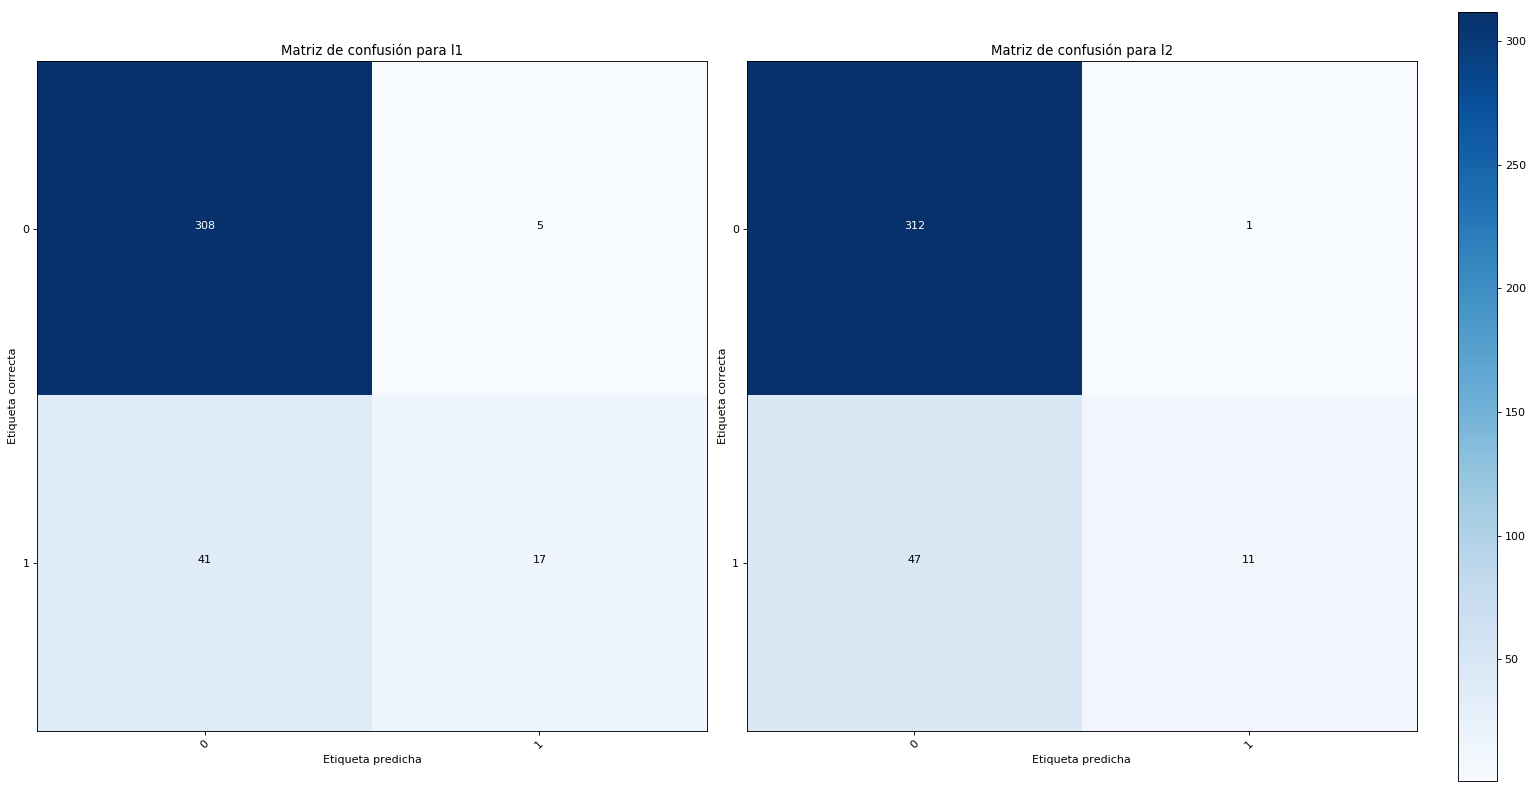

In [32]:
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
  
for idx, penalty in enumerate(('l1', 'l2'), start=1):
    exploring_params = {
        'C': [1./40., 1./30., 1./20., 1./10., 1./1., 1./0.9, 1./0.8, 1./0.5, 1./0.1, 1./0.01],  # Tasa de regularización
        'tol': [1e-3, 1e-5], 
        'max_iter': [10000, 15000, 20000]
    }  
    
    m = LogisticRegression(penalty=penalty)
    model = GridSearchCV(m, exploring_params, cv=5, scoring='roc_auc')
    model.fit(X_train, y_train)
    
    print("####################################################################")
    print("    Exploración de hiperparámetros para función de coste \"%s\"    " % penalty, end="\n")
    print("####################################################################\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")

    print("Puntajes de la grilla:", end="\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
    print()

    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n")
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred), end="\n\n")
    
    print("==================================================================================", end="\n\n")

    plt.subplot(1, 2, idx)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                          classes=[0,1], title="Matriz de confusión para %s" % penalty)

---
## Ejercicio 4: Métricas sobre el conjunto de evaluación

Una vez encontrados los mejores hiperparámetros para el modelo seleccionado en los apartados anteriores se evalúa el modelo final entrenado sobre el conjunto de datos de evaluación seleccionado en el ejercicio 1. Pueden utilizar las métricas que crean convenientes. Es mejor utilizar más de una métrica. Particularmente el *reporte de clasificación* y la *matriz de confusión* son buenos ejemplos de métricas.

In [33]:
# Parametros determinados en el punto anterior:
penalty = 'l2' 
C = 1./0.9      
max_iter = 20000 
tol = 0.001      

model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter, tol=tol, solver='newton-cg')
model.fit(X_train, y_train)

# Evaluamos el desempeño del clasificador utilizando la exactitud (accuracy) sobre el conjunto
# de datos de entrenamiento (X_train, y_train) y lo comparamos con el de validación (X_test, y_test)
# La exactitud toma valor en el rango [0, 1] donde más alto es mejor
print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train, model.predict(X_train)))
print('Exactitud para validación: %.2f' % accuracy_score(y_test, model.predict(X_test)))

Exactitud para entrenamiento: 0.87
Exactitud para validación: 0.88


### Matriz de confusión

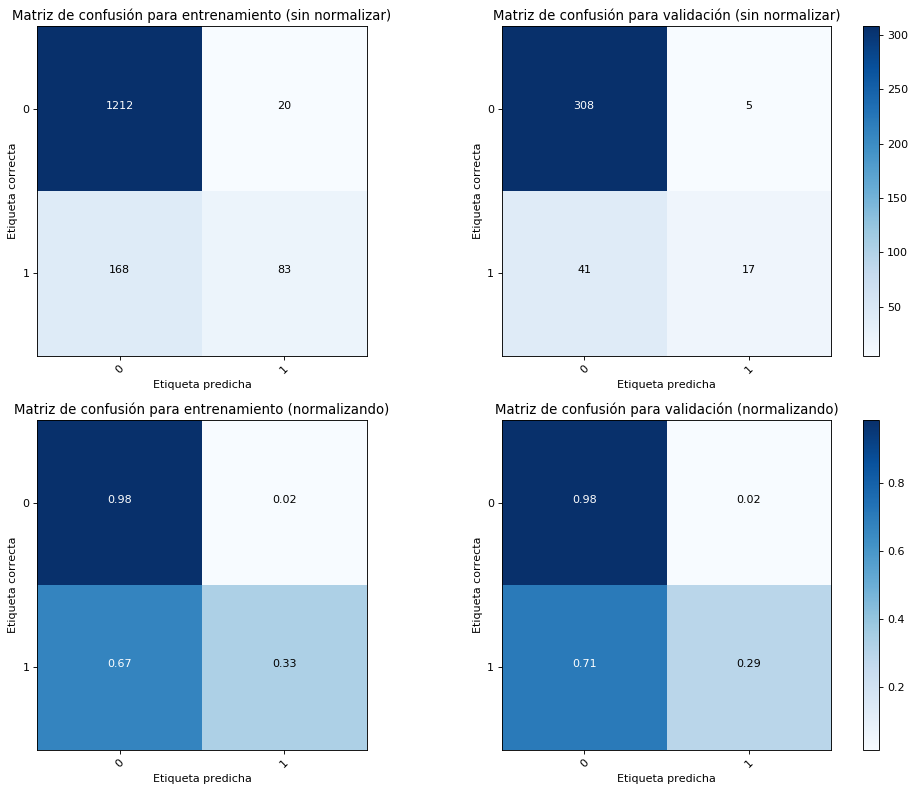

In [34]:
plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train)),
                classes=[0,1],title='Matriz de confusión para entrenamiento (sin normalizar)')
plt.subplot(2, 2, 3)
plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train)),
                classes=[0,1],normalize=True,title='Matriz de confusión para entrenamiento (normalizando)')

plt.subplot(2, 2, 2)
plot_confusion_matrix(confusion_matrix(y_test, model.predict(X_test)),
                classes=[0,1],title='Matriz de confusión para validación (sin normalizar)')
plt.subplot(2, 2, 4)
plot_confusion_matrix(confusion_matrix(y_test, model.predict(X_test)),
                classes=[0,1], normalize=True,title='Matriz de confusión para validación (normalizando)')
plt.show();

In [35]:
print("Reporte de clasificación para el mejor clasificador (sobre conjunto de entrenamiento):", end="\n")
y_true, y_pred = y_train, model.predict(X_train)
print(classification_report(y_true, y_pred), end="\n\n")
    
print("==================================================================================", end="\n\n")

print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n")
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")
    
print("==================================================================================", end="\n\n")

Reporte de clasificación para el mejor clasificador (sobre conjunto de entrenamiento):
             precision    recall  f1-score   support

          0       0.88      0.98      0.93      1232
          1       0.81      0.33      0.47       251

avg / total       0.87      0.87      0.85      1483



Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):
             precision    recall  f1-score   support

          0       0.88      0.98      0.93       313
          1       0.77      0.29      0.42        58

avg / total       0.87      0.88      0.85       371





---
## Ejercicio 5 (opcional): Curvas de ROC

Como ejercicio adicional (opcional), pueden redefinir el umbral de decisión óptimo del problema a partir de los resultados que muestren curvas de ROC como justificación. 

Pueden ver esto mediante la [graficación de las curvas de ROC](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). En el link que se les brinda se muestra como hacer para graficar curvas de ROC para problemas multiclase. Sin embargo se puede adaptar fácilmente a un problema binario obviando la parte donde se calcula la curva clase por clase.

A continuación graficaremos la curva ROC correspondiente a nuestro modelo para poder realizar un análisis del umbral utilizado.

True Positive Rates:
[0.01724138 0.22413793 0.22413793 0.24137931 0.24137931 0.25862069
 0.25862069 0.32758621 0.32758621 0.36206897 0.36206897 0.39655172
 0.39655172 0.43103448 0.43103448 0.46551724 0.46551724 0.48275862
 0.48275862 0.5        0.5        0.51724138 0.51724138 0.53448276
 0.53448276 0.55172414 0.55172414 0.56896552 0.56896552 0.60344828
 0.60344828 0.63793103 0.63793103 0.65517241 0.65517241 0.67241379
 0.67241379 0.70689655 0.70689655 0.72413793 0.72413793 0.74137931
 0.74137931 0.75862069 0.75862069 0.77586207 0.77586207 0.79310345
 0.79310345 0.81034483 0.81034483 0.82758621 0.82758621 0.84482759
 0.84482759 0.86206897 0.86206897 0.87931034 0.87931034 0.89655172
 0.89655172 0.9137931  0.9137931  0.93103448 0.93103448 0.94827586
 0.94827586 0.96551724 0.96551724 0.98275862 0.98275862 1.
 1.        ]
False Positive Rates:
[0.         0.         0.00638978 0.00638978 0.00958466 0.00958466
 0.01597444 0.01597444 0.02555911 0.02555911 0.02875399 0.02875399
 0.04472843 0.

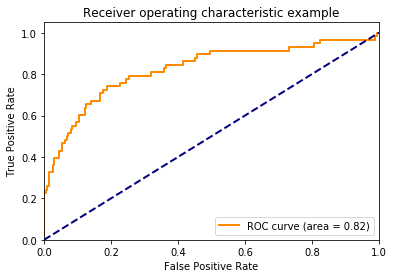

In [36]:
from sklearn.metrics import roc_curve, auc

y_true, y_pred = y_test, model.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label=1)

print("True Positive Rates:")
print(tpr)
print("False Positive Rates:")
print(fpr)
print("Umbrales utilizados en el análisis:")
print(threshold)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

El umbral correspondiente al modelo que utilizamos inicialmente corresponde a un TPR de 0.93 y a un FPR de 0.70 aproximadamente. Esto corresponde a un umbral utilizado muy bajo. Que provoca que nos ubiquemos mas "al final de la curva". Si observamos la matriz de confusión nos encontramos frente a una cantidad considerable de falsos positivos, con lo cual sería deseable disminuir nuestro FPR. Para eso si observamos el gráfico deberíamos acercarnos hacia "el centro de la curva". Nos quedaremos con un FPR de aproximadamente 0.12 y un TPR de aproximadamente 0.65 que corresponde a un umbral de 0.20. Con esto lograremos mejorar nuestros Falsos Positivos, por supuesto a un costo, no muy grande, de true positives.

Exactitud para validación: 0.84


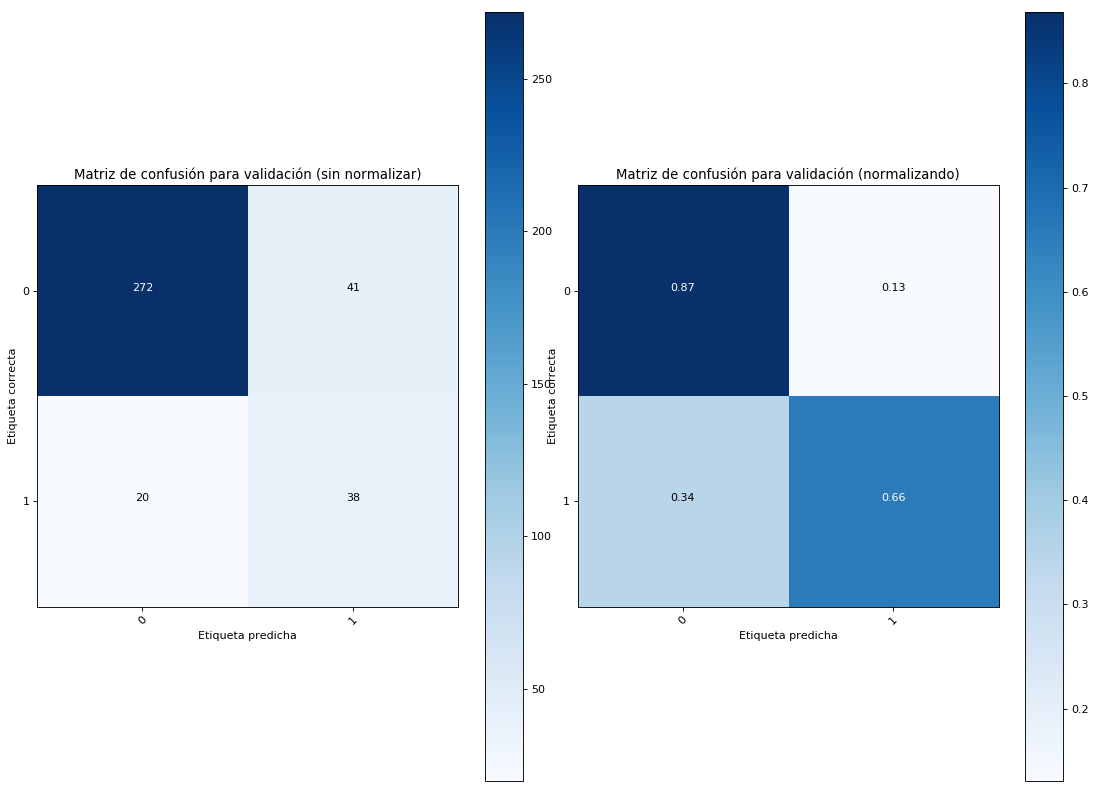

In [37]:
y_pred_bin = []
for prediction in y_pred:
    if prediction > 0.20:
        y_pred_bin.append(1)
    else:
        y_pred_bin.append(0)
        
print('Exactitud para validación: %.2f' % accuracy_score(y_true, y_pred_bin))

plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plot_confusion_matrix(confusion_matrix(y_true, y_pred_bin),
                classes=[0,1],title='Matriz de confusión para validación (sin normalizar)')
plt.subplot(1, 2, 2)
plot_confusion_matrix(confusion_matrix(y_true, y_pred_bin),
                classes=[0,1], normalize=True,title='Matriz de confusión para validación (normalizando)')
plt.show();

Cómo se puede observar hemos disminuido a la mitad los falsos positivos sin afectar practicamente a la precisión.